In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch import tensor
from torch.nn import Linear,ReLU,Sigmoid
import torch.optim as optim
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score,mean_squared_error
from math import sqrt
from torch.utils.tensorboard import SummaryWriter
import warnings;warnings.simplefilter('ignore')

In [2]:
df = pd.read_csv('./train_4521.csv',index_col=0)
df.head()

,T10,T50,T90,N+A,C5NP,C5IP,C5N,C6NP,C6IP,C6N,...,C8N,C8A,C9NP,C9IP,C9N,C9A,C10NP,C10IP,C10N,C10A
0,100.5,119.2,146.5,31.978,0.272,0.132,0.059,5.293,2.570,2.819,...,4.810,5.373,6.405,9.759,4.590,3.661,0.875,5.257,0.525,0.319
1,99.6,117.9,145.5,31.568,0.297,0.151,0.062,5.089,2.531,2.804,...,4.753,5.443,6.324,9.899,4.301,2.995,0.881,5.591,1.119,0.303
2,100.0,118.8,145.6,31.344,0.262,0.126,0.061,5.107,2.571,2.771,...,4.778,5.468,6.360,9.983,4.274,2.979,0.865,5.641,0.964,0.289
3,100.4,118.6,142.9,31.453,0.224,0.105,0.060,4.894,2.497,2.650,...,4.889,5.510,6.444,10.182,4.420,2.964,0.830,5.637,0.968,0.281
4,100.4,118.1,142.2,32.190,0.243,0.117,0.061,4.946,2.503,2.695,...,4.855,5.500,6.416,10.115,4.347,3.725,0.835,4.823,0.969,0.290


# define columns

In [3]:
x_cols = df.columns.tolist()[:4]
t_cols = df.columns.tolist()[:3]
y_cols = df.columns.tolist()[4:]
g_cols = ['C5N',
          'C6N','C6A',
          'C7N','C7A',
          'C8N','C8A',
          'C9N','C9A',
          'C10N','C10A']
h_cols =  ['C5NP','C5IP',
           'C6NP','C6IP',
           'C7NP','C7IP',
           'C8NP','C8IP',
           'C9NP','C9IP',
           'C10NP','C10IP']

# scale

In [4]:
df['raw_NA'] = df['N+A'].values
ss = StandardScaler()
df[x_cols] = ss.fit_transform(df[x_cols])
df = df[x_cols+['raw_NA']+g_cols+h_cols]
df.head()

,T10,T50,T90,N+A,raw_NA,C5N,C6N,C6A,C7N,C7A,...,C6NP,C6IP,C7NP,C7IP,C8NP,C8IP,C9NP,C9IP,C10NP,C10IP
0,0.435162,0.540969,0.471798,-1.028321,31.978,0.059,2.819,0.494,6.411,2.917,...,5.293,2.570,10.395,8.070,9.138,9.649,6.405,9.759,0.875,5.257
1,0.353320,0.340075,0.237602,-1.077598,31.568,0.062,2.804,0.499,6.395,2.894,...,5.089,2.531,10.074,7.958,8.970,9.548,6.324,9.899,0.881,5.591
2,0.389694,0.479156,0.261022,-1.104520,31.344,0.061,2.771,0.492,6.378,2.890,...,5.107,2.571,10.069,7.913,9.006,9.591,6.360,9.983,0.865,5.641
3,0.426068,0.448249,-0.371307,-1.091419,31.453,0.060,2.650,0.469,6.376,2.866,...,4.894,2.497,10.015,7.685,9.133,9.708,6.444,10.182,0.830,5.637
4,0.426068,0.370982,-0.535244,-1.002841,32.190,0.061,2.695,0.477,6.394,2.877,...,4.946,2.503,10.053,7.765,9.101,9.676,6.416,10.115,0.835,4.823


# split

In [5]:
from sklearn.model_selection import train_test_split

X = df[x_cols+['raw_NA']].to_numpy()
Y = df[g_cols+h_cols].to_numpy()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(3164, 5)
(1357, 5)
(3164, 23)
(1357, 23)


# Tensor

In [6]:
X_train = torch.tensor(X_train, dtype=torch.float)
X_test = torch.tensor(X_test, dtype=torch.float)
Y_train = torch.tensor(Y_train, dtype=torch.float)
Y_test = torch.tensor(Y_test, dtype=torch.float)

# data_iter

In [7]:
datasets = torch.utils.data.TensorDataset(X_train, Y_train)
train_iter = torch.utils.data.DataLoader(datasets, batch_size=128, shuffle=True)

# Construct the neural network

In [8]:
class Dual_net(nn.Module):
  def __init__(self,input_shape,g_shape,h_shape):
    super(Dual_net,self).__init__()
    # common fc
    hid = 128
    self.fc1 = nn.Linear(input_shape,hid)
    self.fc2 = nn.Linear(hid,hid)
    self.fc3 = nn.Linear(hid,hid)
    # g
    self.g0 = nn.Linear(hid,hid)
    self.g1 = nn.Linear(hid,hid)
    self.g2 = nn.Linear(hid,g_shape)
    # h
    self.h0 = nn.Linear(hid,hid)
    self.h1 = nn.Linear(hid,hid)
    self.h2 = nn.Linear(hid,h_shape)
    # activation
    self.relu = nn.ReLU()
  
  def forward(self,x):
    # get raw N+A and raw other
    g_total = x[:,4].unsqueeze(1)
    h_total = 100 - g_total
    # only keep scaled_t_cols and scaled_N+A 
    x = x[:,:4]
    # common forward
    x = self.relu(self.fc1(x))
    #x = self.relu(self.fc2(x))
    #x = self.relu(self.fc3(x))
    # forward g and normalize
    #g = self.relu(self.g0(x))
    g = self.g1(x)
    g = F.softmax(self.g2(x),dim=1)*g_total
    # forward h and normalize
    #h = self.relu(self.h0(x))
    h = self.h1(x)
    h = F.softmax(self.h2(x),dim=1)*h_total
    # concat (g,h)
    y = torch.cat((g,h),1)
    return y

In [9]:
def init_weights(m):
  if type(m) == nn.Linear:
    torch.nn.init.xavier_uniform(m.weight)
    m.bias.data.fill_(0)
    print('initialize {}'.format(m))

In [10]:
net = Dual_net(4,11,12)
net.apply(init_weights)

initialize Linear(in_features=4, out_features=128, bias=True)
initialize Linear(in_features=128, out_features=128, bias=True)
initialize Linear(in_features=128, out_features=128, bias=True)
initialize Linear(in_features=128, out_features=128, bias=True)
initialize Linear(in_features=128, out_features=128, bias=True)
initialize Linear(in_features=128, out_features=11, bias=True)
initialize Linear(in_features=128, out_features=128, bias=True)
initialize Linear(in_features=128, out_features=128, bias=True)
initialize Linear(in_features=128, out_features=12, bias=True)


Dual_net(
  (fc1): Linear(in_features=4, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=128, bias=True)
  (g0): Linear(in_features=128, out_features=128, bias=True)
  (g1): Linear(in_features=128, out_features=128, bias=True)
  (g2): Linear(in_features=128, out_features=11, bias=True)
  (h0): Linear(in_features=128, out_features=128, bias=True)
  (h1): Linear(in_features=128, out_features=128, bias=True)
  (h2): Linear(in_features=128, out_features=12, bias=True)
  (relu): ReLU()
)

In [11]:
with SummaryWriter(comment='Net1')as w:
    w.add_graph(net, (X_train,))

# loss_function and optimizer

In [12]:
class RMSELoss(torch.nn.Module):
    def __init__(self):
        super(RMSELoss,self).__init__()

    def forward(self,x,y):
        criterion = nn.MSELoss()
        loss = torch.sqrt(criterion(x, y))
        return loss

In [13]:
loss_function = RMSELoss()
optimizer = optim.Adam(net.parameters(),lr=0.01)

# Training and evaluation

In [14]:
def train(net,train_iter,loss_function,optimizer,num_epochs=100):
  history = []
  for epoch in range(num_epochs):
    for x,y in train_iter:
      loss = loss_function(net(x),y)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    # end for
    print("epochs {} loss {:.4f}".format(epoch,loss.item()))
    if loss.item() < 0.365:
      break
    history.append(loss.item())
  # end for
  plt.plot(np.array(history))
  plt.title('train loss')
  return net

epochs 0 loss 1.0173
epochs 1 loss 0.9566
epochs 2 loss 0.7381
epochs 3 loss 1.1770
epochs 4 loss 0.6170
epochs 5 loss 0.4888
epochs 6 loss 0.5555
epochs 7 loss 0.6007
epochs 8 loss 0.8030
epochs 9 loss 0.7761
epochs 10 loss 0.5136
epochs 11 loss 0.5091
epochs 12 loss 0.7017
epochs 13 loss 0.4535
epochs 14 loss 0.5140
epochs 15 loss 0.9368
epochs 16 loss 0.5231
epochs 17 loss 0.4828
epochs 18 loss 0.6288
epochs 19 loss 0.5265
epochs 20 loss 0.6966
epochs 21 loss 0.6263
epochs 22 loss 0.4970
epochs 23 loss 0.5964
epochs 24 loss 0.8125
epochs 25 loss 0.4440
epochs 26 loss 0.4734
epochs 27 loss 0.5153
epochs 28 loss 0.5795
epochs 29 loss 0.9420
epochs 30 loss 0.7187
epochs 31 loss 0.5023
epochs 32 loss 0.6161
epochs 33 loss 0.9449
epochs 34 loss 0.6129
epochs 35 loss 0.5769
epochs 36 loss 0.9274
epochs 37 loss 1.0162
epochs 38 loss 0.6793
epochs 39 loss 0.6656
epochs 40 loss 0.5439
epochs 41 loss 0.5917
epochs 42 loss 0.5604
epochs 43 loss 0.5275
epochs 44 loss 0.5637
epochs 45 loss 0.562

Dual_net(
  (fc1): Linear(in_features=4, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=128, bias=True)
  (g0): Linear(in_features=128, out_features=128, bias=True)
  (g1): Linear(in_features=128, out_features=128, bias=True)
  (g2): Linear(in_features=128, out_features=11, bias=True)
  (h0): Linear(in_features=128, out_features=128, bias=True)
  (h1): Linear(in_features=128, out_features=128, bias=True)
  (h2): Linear(in_features=128, out_features=12, bias=True)
  (relu): ReLU()
)

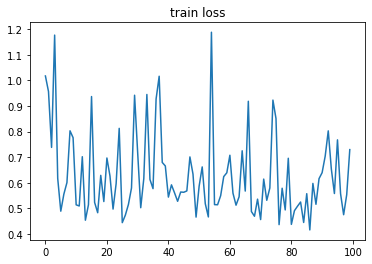

In [15]:
train(net,train_iter,loss_function,optimizer,num_epochs=100)

# predict

In [16]:
y_pred = net(X_test).detach().numpy()
y_real = Y_test.detach().numpy()
y_pred = pd.DataFrame(y_pred,columns=g_cols+h_cols)[y_cols]
y_real = pd.DataFrame(y_real,columns=g_cols+h_cols)[y_cols]

In [17]:
y_pred.head()

,C5NP,C5IP,C5N,C6NP,C6IP,C6N,C6A,C7NP,C7IP,C7N,...,C8N,C8A,C9NP,C9IP,C9N,C9A,C10NP,C10IP,C10N,C10A
0,0.446059,0.353477,0.059669,4.241271,1.818426,2.611002,0.635359,10.645707,8.002942,6.478195,...,4.969000,5.538429,6.465630,9.794038,4.635688,3.459317,0.978799,5.225086,0.523664,0.432160
1,9.283545,7.498031,0.961696,6.131291,7.968861,6.464196,1.865532,5.679253,5.998920,10.702380,...,5.691753,3.611328,2.430819,4.433942,3.143358,1.522901,0.959789,2.486799,0.503789,0.707712
2,0.212321,0.151289,0.034460,3.262112,1.048707,2.172543,0.410182,11.057787,8.240223,6.719213,...,5.209793,6.033241,6.721642,10.235843,4.789011,3.552770,0.764856,5.248863,0.533901,0.390509
3,0.237069,0.175356,0.033892,3.548546,1.217579,2.246128,0.408090,10.967260,8.189749,6.473478,...,5.030579,5.716915,6.644398,10.273664,4.673468,3.548400,0.914817,5.425435,0.551970,0.468774
4,2.332438,1.454727,0.307821,3.069680,3.037977,5.263232,0.779239,5.918625,6.159680,18.148674,...,9.575996,4.871740,2.941012,6.898555,5.247983,2.177841,0.770037,3.967865,0.714375,0.701441


In [18]:
y_real.head()

,C5NP,C5IP,C5N,C6NP,C6IP,C6N,C6A,C7NP,C7IP,C7N,...,C8N,C8A,C9NP,C9IP,C9N,C9A,C10NP,C10IP,C10N,C10A
0,0.428,0.242,0.052,4.339,1.800,2.475,0.488,10.614,7.778,6.648000,...,5.017,5.354,6.320,9.887,4.828,3.368,0.919,5.034,0.541,0.435
1,7.850,5.467,0.780,7.012,7.951,7.060,2.426,5.701,6.196,10.217000,...,5.342,3.367,2.464,4.781,3.126,1.654,1.081,2.849,0.559,0.759
2,0.233,0.175,0.025,3.026,0.786,2.314,0.389,10.812,7.907,7.313000,...,5.221,5.787,6.614,10.756,4.250,3.384,0.735,4.688,0.585,0.326
3,0.046,0.024,0.012,3.892,1.266,2.199,0.401,10.848,7.669,6.472000,...,5.208,5.487,6.508,10.085,4.992,3.303,0.815,4.901,0.499,0.369
4,2.306,1.492,0.277,2.732,2.560,4.559,0.609,5.690,5.916,18.572001,...,9.576,4.610,2.546,7.436,5.706,2.365,0.747,4.039,0.823,0.782


In [19]:
res = pd.DataFrame(index=y_cols,columns=['R2','RMSE'])
for i in y_cols:
  res.loc[i,'R2'] = r2_score(y_real[i],y_pred[i])
  res.loc[i,'RMSE'] = sqrt(mean_squared_error(y_real[i],y_pred[i]))
res.loc['AVG'] = res.mean(axis=0)
res

,R2,RMSE
C5NP,0.901252,0.693736
C5IP,0.831927,0.653652
C5N,0.63275,0.148338
C6NP,0.712572,0.65867
C6IP,0.850568,0.690113
C6N,0.816244,0.816651
C6A,0.785362,0.848696
C7NP,0.937973,0.590224
C7IP,0.860412,0.612833
C7N,0.913635,1.36297


In [20]:
temp = pd.DataFrame()
temp['real'] = y_real[g_cols].sum(axis=1).values
temp['pred'] = y_pred[g_cols].sum(axis=1).values
temp

,real,pred
0,32.206001,32.206001
1,38.450001,38.450005
2,32.807003,32.806992
3,32.024002,32.023994
4,51.471004,51.470997
...,...,...
1352,35.746998,35.747002
1353,38.218998,38.219002
1354,45.647999,45.647995
1355,56.240997,56.241001
